## Notebook 3.

This notebook aims to incorporate weather info as covariates to further enrich our models.

The preparation of the daily weather info was done in a separate notebook. Weather variables including min/max/mean temperature, rainfall, wind speed, wind direction, gust speed, humidity, sunlight intensity are captured. We had three weather stations: Bana, Pala, Souroukoudingan. Bana market and Bana village uses the same weather info.

We begin by loading the required datasets and packages into the currect R session. 

In [1]:
# LOAD PACKAGES
require(compiler)
enableJIT(3)
require(doParallel)
require(lme4)
require(lmerTest)
require(MASS)
setMKLthreads(22)
# LOAD COUNT DATASET
load('Per house data PSC 2012 to 2019 polish2.RData')
# LOAD WEATHER INFO DATASETS
load('BF_weather.RData')
ls()

Loading required package: compiler


[1] 3

Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: lme4
Loading required package: Matrix
Loading required package: lmerTest

Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step

Loading required package: MASS


[1] "BV_weather" "dat1"       "PL_weather" "SK_weather"

In [2]:
# LOOK AT THE FIRST FEW ROWS OF WEATHER INFO
head(BV_weather)
# VARIABLE NAMES
names(BV_weather)

date,meantemp.c,maxtemp.c,mintemp.c,humidity.percent,winddir.deg,windspeed.kmhr,gustspeed.kmhr,rain.mm,sun.wma2
2014-07-31,27.79938,32.742,24.098,78.11377,204.6935,0.6704348,3.153841,0.0,224.0761
2014-08-01,26.46952,32.536,22.633,83.48438,191.1722,1.6741667,6.360660,5.4,206.9358
2014-08-02,26.09427,31.459,21.628,80.71215,188.3132,0.9368403,5.585556,0.0,236.3309
2014-08-03,25.43908,31.689,21.676,83.75208,187.1885,1.1211806,5.052535,0.2,199.4365
2014-08-04,25.57674,30.874,23.136,85.59410,207.0135,1.0736111,5.181632,1.0,158.8788
2014-08-05,25.20164,31.663,22.417,86.57118,217.7208,0.9179167,5.496701,2.2,215.0361


[1] "date"             "meantemp.c"       "maxtemp.c"        "mintemp.c"       
 [5] "humidity.percent" "winddir.deg"      "windspeed.kmhr"   "gustspeed.kmhr"  
 [9] "rain.mm"          "sun.wma2"

The count dataset is called dat1. This time we also have three weather info files BV_weather, PL_weather, SK_weather, one for each location. 

The variable names in the weather info are quite self-explanatory. Each row is a day. The first column is date (R-formatted) which will be used as the key for apending weather info to the main count dataset. Basic arithmetic operations such as addition and subtraction are permitted to the date column. All three weather info files have the same columns. 

Next we take a subset of of the count dataset. This is because weather info is only available to year 2017-2019, and also that we focus on the wet seasons' counts. From the cell below we have 876 rows after subsetting, which is ~1/4 of the original size. It is slightly unfortunate but we have to make the most of it. 

In [3]:
# TAKE SUBSET, YEAR 2017-2019 WHEN WEATHER INFO IS AVAILABLE
dat2<-dat1[dat1$date.collection>=min(PL_weather$date),]
# TAKE SUBSET, WET SEASON COUNTS ONLY (MAY TO OCTOBER ONLY)
dat2<-dat2[dat2$month.assigned %in% 5:10,]
# DIMENSION OF THE NEW SUBSET?
dim(dat2)
#names(dat2)
rm(dat1)
# TRANSFORM num.persons
dat2$persons.status<-dat2$num.persons
dat2$persons.status[dat2$num.persons>3]<-'Hi'
dat2$persons.status[dat2$num.persons<=3]<-'Low'
dat2$persons.status[dat2$num.persons==0]<-'None'

[1] 876  26

### Time-series plots
Let us make some plots to see if there is any obvious relationship between the variables. The first plots are some time-series plots on the daily mean temperature, rainfall, and mean count, all on the same time axis. We have three sets of plots for Bana, Sourou, and Pala:

Each dot is the mean female mosquito count from the same day. 

[1] 32

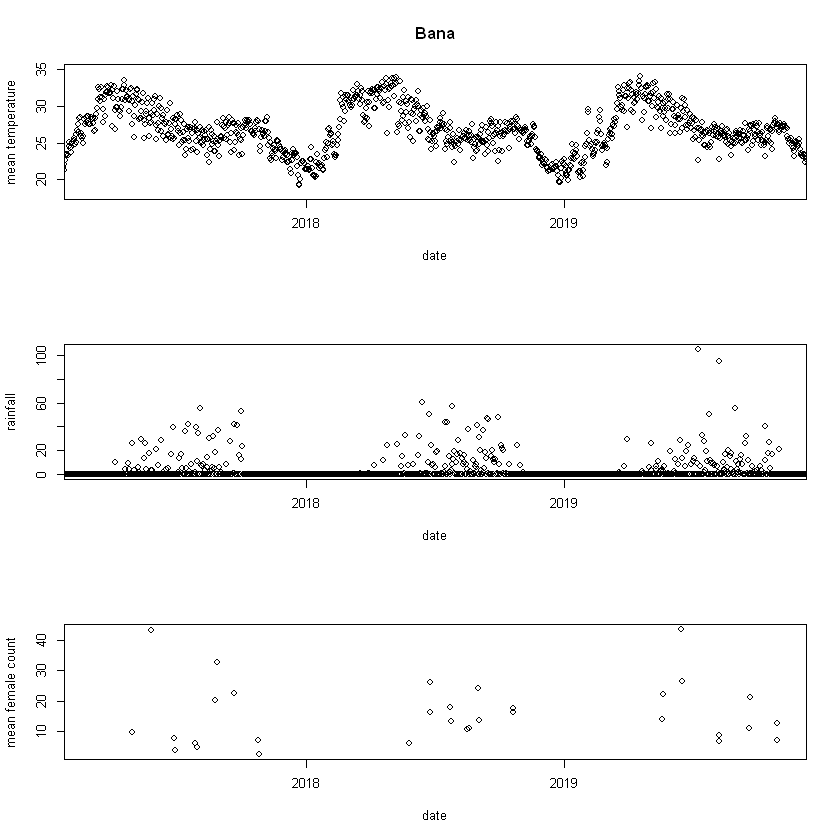

In [4]:
# LOOK AT BANA (MARKET AND VILLAGE)
dat3<-dat2[dat2$village %in% c('Bana market', 'Bana village'),]
dat3<-dat3[dat3$year.assigned %in% 2017:2019,]
#dim(dat3)
# CALCULATE THE MEAN COUNT PER DAY
date<-unique(dat3$date.collection)
date<-as.Date(date, '%d/%m/%Y')
mean_count<-rep(NA, length(date))
length(date)
for (i in 1:length(date)) {mean_count[i]<-mean(dat3$count.f[dat3$date.collection==date[i]], na.rm=T)}
temp<-merge(BV_weather[,c(1,2,9)], cbind(date, mean_count), by=1, all.x=T)
par(mfrow=c(3,1))
plot(temp$date, temp$meantemp.c, xlim=c(17230, 18200), main='Bana', xlab='date', ylab='mean temperature')
plot(temp$date, temp$rain.mm, xlim=c(17230, 18200), xlab='date', ylab='rainfall')
plot(temp$date, temp$mean_count, xlim=c(17230, 18200), xlab='date', ylab='mean female count')
rm(dat3); rm(temp);
#min(as.numeric(date))

[1] 180  27

[1] 9

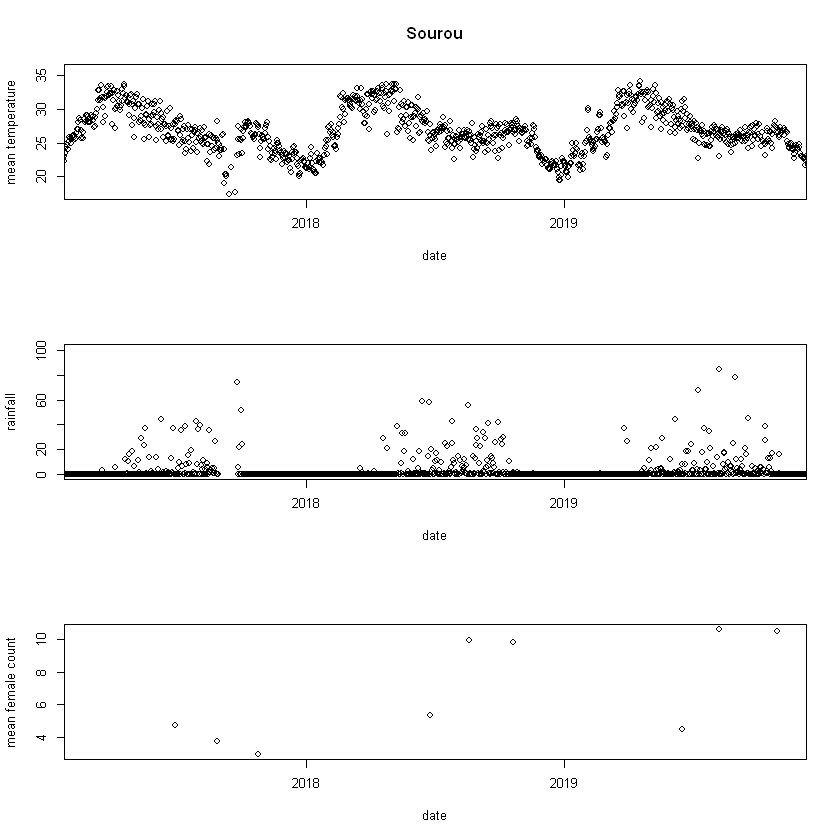

In [5]:
# LOOK AT SOUROU DATA
dat3<-dat2[dat2$village %in% 'Souroukoudingan',]
dat3<-dat3[dat3$year.assigned %in% 2017:2019,]
dim(dat3)
# CALCULATE THE MEAN COUNT PER DAY
date<-unique(dat3$date.collection)
date<-as.Date(date, '%d/%m/%Y')
mean_count<-rep(NA, length(date))
length(date)
for (i in 1:length(date)) {mean_count[i]<-mean(dat3$count.f[dat3$date.collection==date[i]], na.rm=T)}
temp<-merge(SK_weather[,c(1,2,9)], cbind(date, mean_count), by=1, all.x=T)
par(mfrow=c(3,1))
plot(temp$date, temp$meantemp.c, xlim=c(17230, 18200), main='Sourou', xlab='date', ylab='mean temperature')
plot(temp$date, temp$rain.mm, xlim=c(17230, 18200), xlab='date', ylab='rainfall')
plot(temp$date, temp$mean_count, xlim=c(17230, 18200), xlab='date', ylab='mean female count')
rm(dat3); rm(temp);
#min(as.numeric(date))

[1] 14

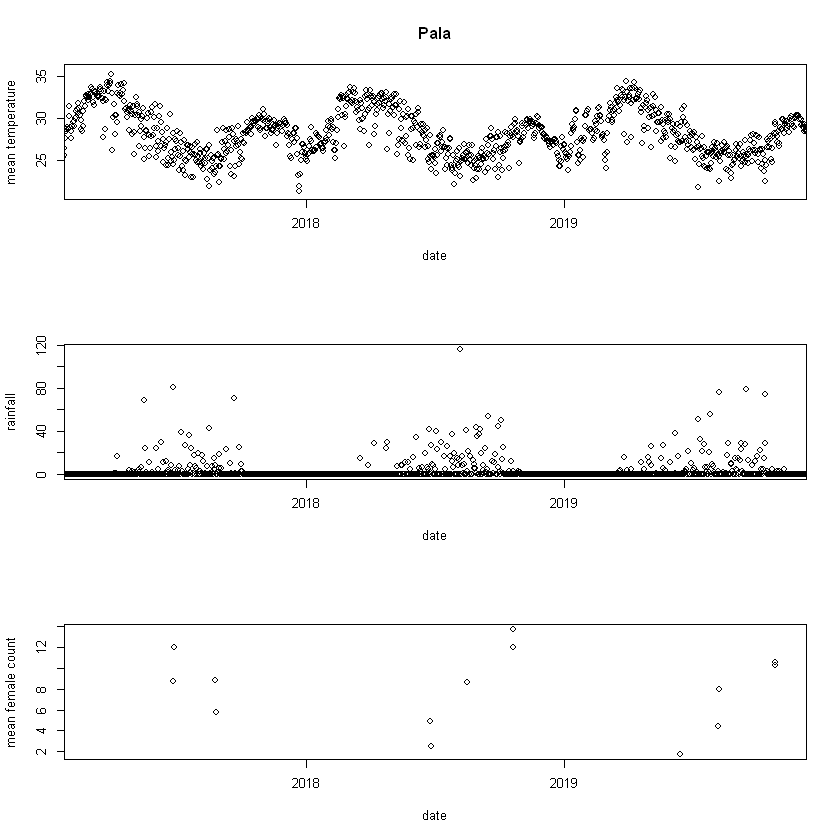

In [6]:
# LOOK AT PALA DATA
dat3<-dat2[dat2$village %in% 'Pala',]
dat3<-dat3[dat3$year.assigned %in% 2017:2019,]
#dim(dat3)
# CALCULATE THE MEAN COUNT PER DAY
date<-unique(dat3$date.collection)
date<-as.Date(date, '%d/%m/%Y')
mean_count<-rep(NA, length(date))
length(date)
for (i in 1:length(date)) {mean_count[i]<-mean(dat3$count.f[dat3$date.collection==date[i]], na.rm=T)}
temp<-merge(PL_weather[,c(1,2,9)], cbind(date, mean_count), by=1, all.x=T)
par(mfrow=c(3,1))
plot(temp$date, temp$meantemp.c, xlim=c(17230, 18200), main='Pala', xlab='date', ylab='mean temperature')
plot(temp$date, temp$rain.mm, xlim=c(17230, 18200), xlab='date', ylab='rainfall')
plot(temp$date, temp$mean_count, xlim=c(17230, 18200), xlab='date', ylab='mean female count')
rm(dat3); rm(temp);
#min(as.numeric(date))

1) Although there are 876 data points they came from only 55 unique weather conditions (unique day and village combinations). 2) It seems that the count is lower when the temperature reaches its peak at the early wet season. Apart from this I don't see any obvious patterns. 3) Counts from 2017 look different compared to 2018 and 2019. 4) As seen below there is a huge variation in counts even under the same weather condition. 

Next we want to do some modelling, but before that we need to merge the weather info to the count dataset. We use the date columns as the key for merging. Furthermore, I want to append not weather info not only on the date of sampling but also several days before it. Below is the script to do this. You don't have to read it. 

In [7]:
# A FUNCTION TO APPEND WEATHER INFO USING DATE. WITH LAGS
# ALWAYS GET FROM dat2
# YOU CAN IGNORE IT
f<-function(lag=0, lag_length=10)
{
    temp_date<-dat2$date.collection
    temp_village<-dat2$village
    # ONE PER VILLAGE
    temp<-data.frame(matrix(nc=lag_length, nr=length(temp_date)))
    temp_rain_SK<-temp; temp_rain_PL<-temp; temp_rain_BV<-temp;
    temp_temp_SK<-temp; temp_temp_PL<-temp; temp_temp_BV<-temp;
    temp_humid_SK<-temp; temp_humid_PL<-temp; temp_humid_BV<-temp;
    temp_wind_SK<-temp; temp_wind_PL<-temp; temp_wind_BV<-temp;
    temp_sun_SK<-temp; temp_sun_PL<-temp; temp_sun_BV<-temp;
    # THE COMBINED
    temp_rain<-temp; temp_temp<-temp; 
    temp_humid<-temp; temp_wind<-temp;
    temp_sun<-temp;
    for (i in 1:lag_length)
        {
        temp<-merge(temp_date-lag-i+1, SK_weather, by=1, all.x=T)
        temp_temp_SK[,i]<-temp[,2]
        temp_rain_SK[,i]<-temp[,9]
        temp_humid_SK[,i]<-temp[,5]
        temp_wind_SK[,i]<-temp[,7]
        temp_sun_SK[,i]<-temp[,10]
        temp<-merge(temp_date-lag-i+1, PL_weather, by=1, all.x=T)
        temp_temp_PL[,i]<-temp[,2]
        temp_rain_PL[,i]<-temp[,9]
        temp_humid_PL[,i]<-temp[,5]
        temp_wind_PL[,i]<-temp[,7]
        temp_sun_PL[,i]<-temp[,10]
        temp<-merge(temp_date-lag-i+1, BV_weather, by=1, all.x=T)
        temp_temp_BV[,i]<-temp[,2]
        temp_rain_BV[,i]<-temp[,9]
        temp_humid_BV[,i]<-temp[,5]
        temp_wind_BV[,i]<-temp[,7]
        temp_sun_BV[,i]<-temp[,10]
        }
    # NOW APPEND 
    SK<-temp_village=='Souroukoudingan'
    PL<-temp_village=='Pala'
    BV<-temp_village %in% c('Bana village', 'Bana market')
    temp_rain[SK,]<-temp_rain_SK[SK,]; temp_rain[PL,]<-temp_rain_PL[PL,]; temp_rain[BV,]<-temp_rain_BV[BV,]; 
    temp_temp[SK,]<-temp_temp_SK[SK,]; temp_temp[PL,]<-temp_temp_PL[PL,]; temp_temp[BV,]<-temp_temp_BV[BV,]; 
    temp_humid[SK,]<-temp_humid_SK[SK,]; temp_humid[PL,]<-temp_humid_PL[PL,]; temp_humid[BV,]<-temp_humid_BV[BV,]; 
    temp_wind[SK,]<-temp_wind_SK[SK,]; temp_wind[PL,]<-temp_wind_PL[PL,]; temp_wind[BV,]<-temp_wind_BV[BV,]; 
    temp_sun[SK,]<-temp_sun_SK[SK,]; temp_sun[PL,]<-temp_sun_PL[PL,]; temp_sun[BV,]<-temp_sun_BV[BV,]; 
    
    # GIVE COLUMN NAMES
    for (i in 1:lag_length)
        {
        names(temp_rain)[i]<-paste(c('rain.minus.', abs(-lag-i+1)), collapse='')
        names(temp_temp)[i]<-paste(c('temp.minus.', abs(-lag-i+1)), collapse='')
        names(temp_humid)[i]<-paste(c('humid.minus.', abs(-lag-i+1)), collapse='')
        names(temp_wind)[i]<-paste(c('wind.minus.', abs(-lag-i+1)), collapse='')
        names(temp_sun)[i]<-paste(c('sun.minus', abs(-lag-i+1)), collapse='')
        }
    return(cbind(dat2, temp_rain, temp_temp, temp_humid, temp_wind, temp_sun))
}
f<-cmpfun(f)

In [8]:
# LET'S TRY IT
names(f(lag=0, lag_length=1))

[1] "village"            "month.assigned"     "year.assigned"     
 [4] "monthyear.assigned" "day"                "month"             
 [7] "year"               "date.collection"    "site.id"           
[10] "longitude"          "latitude"           "room.id"           
[13] "num.persons"        "num.persons.remark" "mosquito.net"      
[16] "permanence"         "count.m"            "genotyped.m"       
[19] "col.m"              "gam.m"              "arab.m"            
[22] "count.f"            "genotyped.f"        "col.f"             
[25] "gam.f"              "arab.f"             "persons.status"    
[28] "rain.minus.0"       "temp.minus.0"       "humid.minus.0"     
[31] "wind.minus.0"       "sun.minus0"

Weather info variables are appended to the original count dataset. For example, rain.minus.0 is the rainfall on the day of sampling (hence with suffices minus.0 day). We can add past weather info by changing the arguments of the function f(). 

### plots with day 0 weather info only
Let us focus on day 0's weather info. Running some plots may help feel the relationship between the counts and the two weather variables of interest: 

[1] -0.03348334

[1] 0.1014205

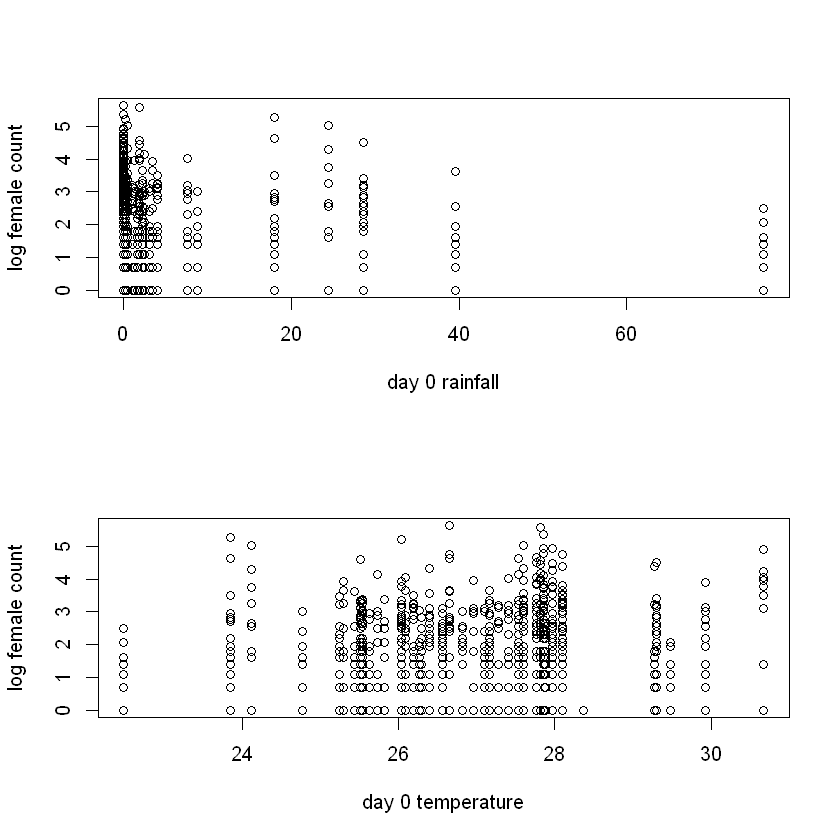

In [9]:
dat3<-f(lag=0, lag_length=1)
par(mfrow=c(2,1))
# PLOT EACH LOG FEMALE COUNT AGAINST A WEATHER VARIABLE
plot(dat3$rain.minus.0, log(dat3$count.f+1), xlab='day 0 rainfall', ylab='log female count')
plot(dat3$temp.minus.0, log(dat3$count.f+1), xlab='day 0 temperature', ylab='log female count')
# CORRELATION COEFFICIENT (WEAK)
cor(dat3$rain.minus.0, log(dat3$count.f+1), use='pairwise')
cor(dat3$temp.minus.0, log(dat3$count.f+1), use='pairwise')

Again I do not see any obvious trends, but it seems there is a weak correlation between log female count and temperature. Let us build some models with these two weather variables. We build two models here: 1A with linear rainfall and temperature from day 0, 1B with quadratic terms. 

### model 1. With day 0 temperature and rainfall

In [10]:
# MODEL 1A. DAY 0 TEMPERATURE AND RAINFALL, LINEAR
dat3<-f(lag=0, lag_length=1)
overdispersion<-1:nrow(dat3)
dat3$rain.minus.0<-scale(dat3$rain.minus.0) # SCALING
dat3$temp.minus.0<-scale(dat3$temp.minus.0)
m_1A<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+mosquito.net+persons.status
            +rain.minus.0+temp.minus.0, 
             family='poisson', data=dat3, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_1A, correlation=FALSE)

boundary (singular) fit: see ?isSingular


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    mosquito.net + persons.status + rain.minus.0 + temp.minus.0
   Data: dat3
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5668.4   5711.0  -2825.2   5650.4      833 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.30607 -0.35956 -0.01262  0.14205  0.53442 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.2472   1.117   
 site.id        (Intercept) 0.8372   0.915   
 year.assigned  (Intercept) 0.0000   0.000   
Number of obs: 842, groups:  
overdispersion, 842; site.id, 174; year.assigned, 3

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         1.70405    0.19982   8.528  < 2e-16 ***
mosquito.netYes    

In [11]:
# MODEL 1B. DAY 0 TEMPERATURE AND RAINFALL, ADD QUADRATIC VIA I(rain.minus.0^2)
dat3<-f(lag=0, lag_length=1)
overdispersion<-1:nrow(dat3)
dat3$rain.minus.0<-scale(dat3$rain.minus.0) # SCALING
dat3$temp.minus.0<-scale(dat3$temp.minus.0)
m_1B<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+mosquito.net+persons.status
            +rain.minus.0+I(rain.minus.0^2)+temp.minus.0+I(temp.minus.0^2), 
             family='poisson', data=dat3, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_1B, correlation=FALSE)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    mosquito.net + persons.status + rain.minus.0 + I(rain.minus.0^2) +  
    temp.minus.0 + I(temp.minus.0^2)
   Data: dat3
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5668.2   5720.3  -2823.1   5646.2      831 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.31675 -0.35550 -0.01144  0.14330  0.47555 

Random effects:
 Groups         Name        Variance  Std.Dev.
 overdispersion (Intercept) 1.2313087 1.10964 
 site.id        (Intercept) 0.8429662 0.91813 
 year.assigned  (Intercept) 0.0003555 0.01886 
Number of obs: 842, groups:  
overdispersion, 842; site.id, 174; year.assigned, 3

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         1.72467  

We have three observations here: First, after including day 0's rainfall and temperature we can get rid of the year effect, as its variance is estimated to be 0. Second, day o's temperature seems to a significant covariate. 

The scaling of variables is nothing but a mathematical trick for faster convergence. 


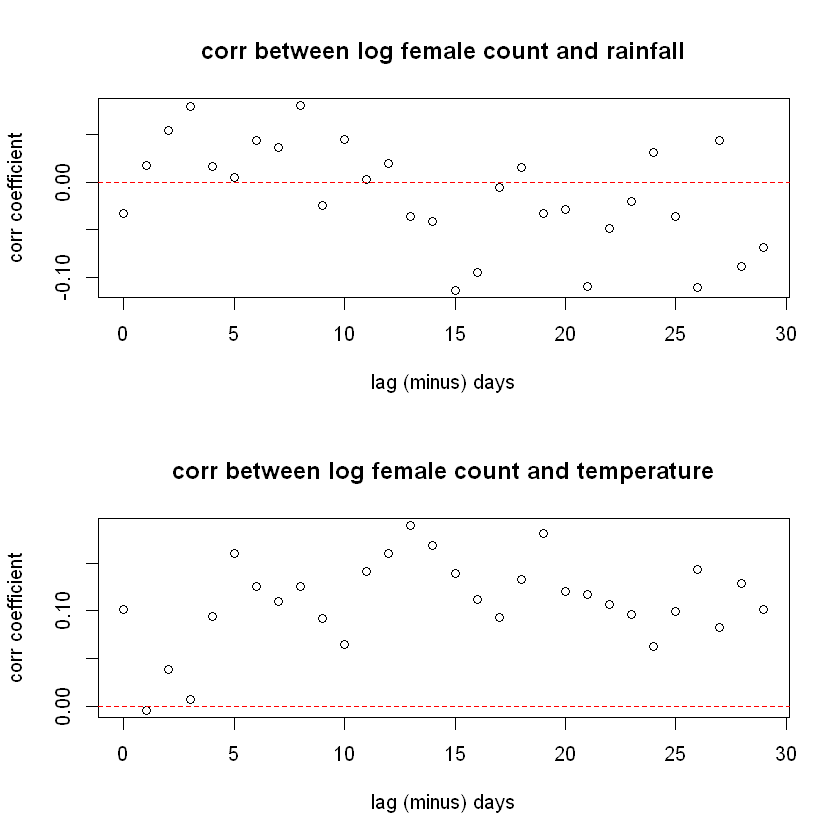

In [12]:
dat3<-f(lag=0, lag_length=75)
# names(dat3)[c(28, 75)] 
corr_temp<-rep(NA, 30)
corr_rain<-rep(NA, 30)
for (i in 1:30)
    {
    corr_rain[i]<-cor(dat3[,28+i-1], log(dat3$count.f+1), use='pairwise')
    corr_temp[i]<-cor(dat3[,28+75+i-1], log(dat3$count.f+1), use='pairwise')
}
par(mfrow=c(2,1))
plot(0:29, corr_rain, xlab='lag (minus) days', ylab='corr coefficient', main='corr between log female count and rainfall')
abline(h=0, col='red', lty=2)
plot(0:29, corr_temp, xlab='lag (minus) days', ylab='corr coefficient', main='corr between log female count and temperature')
abline(h=0, col='red', lty=2)

### Include lagged rainfall as covariate

We now try to build more complex models which use the sum of rainfall in the previous days as a covariate. To be exact, we want to use the sum of rainfall between i and (i+j-1) days ago as the covariate. To find the best values for i and j, we run many glms with different combinations, and choose the one with the highest log-likelihood. 

In [11]:
dat3<-f(lag=0, lag_length=75)
#dim(dat3)
cat(paste('The 28-th column is', names(dat3)[28])) # MAKE SURE THE 28-TH COLUMN IS rain.minus.0
cl<-makeCluster(46, outfile='log.txt') # MULTIPLE CPU
registerDoParallel(cl)
result_rain<-foreach (i=1:30, .combine=rbind, .packages='lme4') %dopar%
    {
    setMKLthreads(1)
    temp_result<-rep(NA, 21)
    for (j in 1:length(temp_result))
        {
        total.rain<-apply(as.matrix(dat3[,(i+28):(i+28+j-1)]), 1, mean, na.rm=T)
        total.rain<-scale(total.rain) # SCALE TO CENTRE
        dat3$rain.minus.0<-scale(dat3$rain.minus.0)
        dat3$temp.minus.0<-scale(dat3$temp.minus.0)
        overdispersion<-1:nrow(dat3)
        m<-NA #RESET m
        m<-glmer(count.f~(1|site.id)+(1|overdispersion)+mosquito.net+persons.status
             +rain.minus.0+I(rain.minus.0^2)+temp.minus.0+total.rain, 
            data=dat3, family='poisson', 
            control=glmerControl(optimizer="bobyqa"))
        temp_result[j]<-summary(m)$logLik
        cat(sprintf("%i, %i\n", i, j))
        }
    return(temp_result)
    }
stopCluster(cl)
dim(result_rain)
invisible(gc())

The 28-th column is rain.minus.0

[1] 30 21

[1] -2813.917

,row,col
result.3,3,1


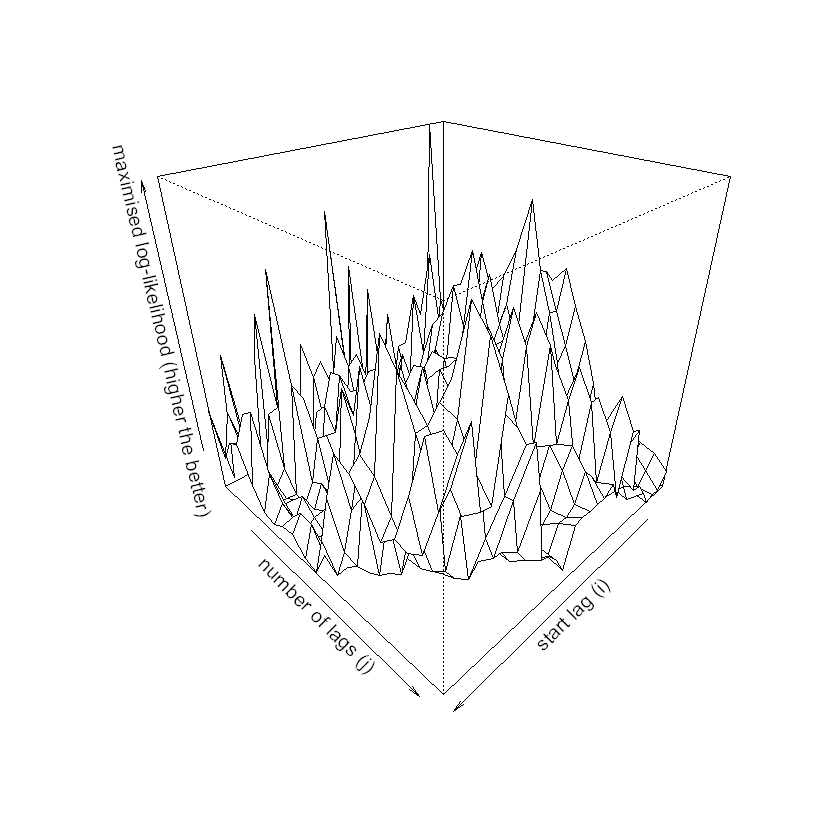

In [12]:
persp(1:nrow(result_rain), 1:ncol(result_rain), result_rain, theta=135, phi=30, 
        xlab='start lag (i)', ylab='number of lags (j)', zlab='maximised log-likelihood (higher the better)')
# HIGHEST LOG-LIKE
max(result_rain, na.rm=T)
# THE VALUE OF i AND j GIVES THE HIGHEST LOG-LIKE
which(result_rain==max(result_rain, na.rm=T), arr.ind=TRUE)

It takes a while to run hundreds of glms. Now we plot the maximised log-likelihood against i and j in a 3D plot. We also would like to know which combination of i and j gives the highest log-likelihood. 

The best fit is when i=3 and j=1 (i.e. the rainfall 3 days ago). I am not convinced. 

Ace suggested to use a Gaussian-like weighted sum for rainfall. 

In [14]:
dat3<-f(lag=0, lag_length=75)
cat(paste('The 28-th column is', names(dat3)[28])) # MAKE SURE THE 28-TH COLUMN IS rain.minus.0
cl<-makeCluster(46, outfile='log.txt') # MULTIPLE CPU
registerDoParallel(cl)
result_rain_gaussian<-foreach (i=1:30, .combine=rbind, .packages='lme4') %dopar%
    {
    setMKLthreads(1)
    sd<-seq(0.4, 4, 0.4) # MAX SD CONSIDERED IS 4
    temp_result<-rep(NA, length(sd))
    for (j in 1:length(temp_result))
        {
        # FIGURE OUT THE GAUSSIAN MAX AND MIN, CUT-OFF IS 3*SD
        lower<-floor(i-3*sd[j])
        if (lower<1) {lower<-1} # CAN'T HAVE NEGATIVE LAGS
        upper<-ceiling(i+3*sd[j])
        temp<-dnorm(lower:upper, mean=i, sd=sd[j])
        weight<-temp/sum(temp) # NORMALISE WEIGHTS, SUM TO ONE
        temp.total.rain<-as.matrix(dat3[,(lower+28):(upper+28)])
        total.rain<-as.vector(temp.total.rain%*%weight)
        total.rain<-scale(total.rain) # SCALE TO CENTRE
        dat3$rain.minus.0<-scale(dat3$rain.minus.0)
        dat3$temp.minus.0<-scale(dat3$temp.minus.0)
        overdispersion<-1:nrow(dat3)
        m<-NA # RESET
        m<-glmer(count.f~(1|site.id)+(1|overdispersion)+village+month.assigned+mosquito.net+persons.status
             +rain.minus.0+temp.minus.0+total.rain, 
            data=dat3, family='poisson', 
            control=glmerControl(optimizer="bobyqa"))
        temp_result[j]<-summary(m)$logLik
        cat(sprintf("%i, %i\n", i, j))
        }
    return(temp_result)
    }
stopCluster(cl)
dim(result_rain_gaussian)
invisible(gc())

The 28-th column is rain.minus.0

[1] 30 10

[1] -2789.546

,row,col
result.16,16,1


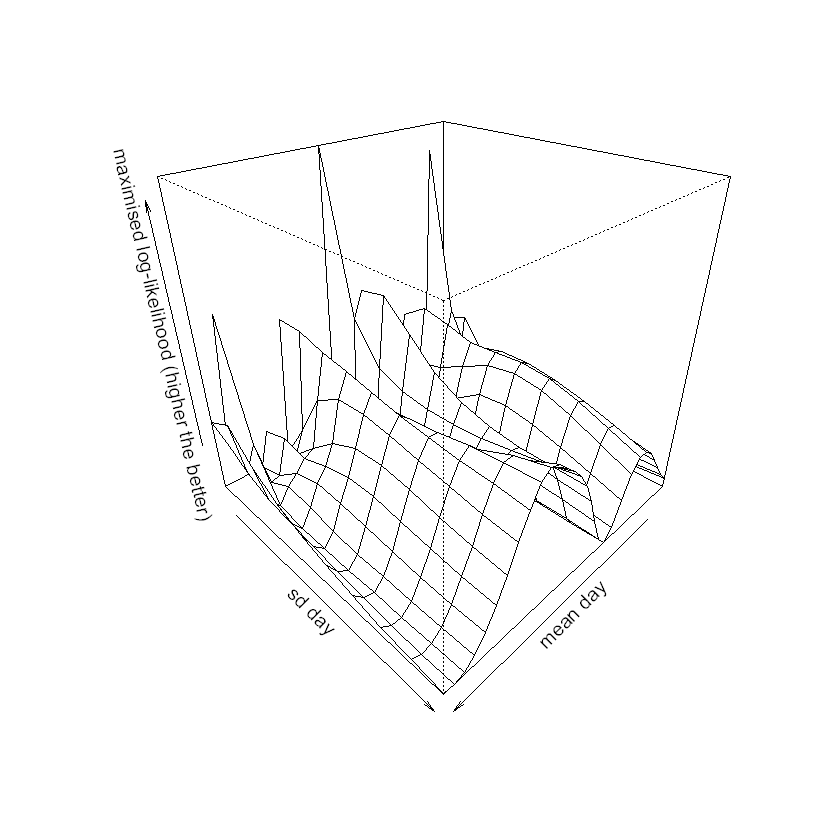

In [15]:
persp(1:nrow(result_rain_gaussian), 1:ncol(result_rain_gaussian), result_rain_gaussian, theta=135, phi=30, 
        xlab='mean day', ylab='sd day', zlab='maximised log-likelihood (higher the better)')
max(result_rain_gaussian, na.rm=T)
which(result_rain_gaussian==max(result_rain_gaussian, na.rm=T), arr.ind=TRUE)

This suggests that the best fit is when mean day=16 with the smallest sd=0.4. Also noticed the second highest peak is around day=3 which gives the same estimate as the previous model. 

No definitive answer. Maybe I should run a poisson regression on the mean count. 

In [10]:
# CREATE A DATA FRAME WHOSE RESPONSE IS THE MEAN COUNT ON THE SAME DAY
dat3<-f(lag=0, lag_length=75)
dat4<-data.frame(matrix(nc=ncol(dat3), nr=55)) # 55 UNIQUE WEATHER CONDITIONS
names(dat4)<-names(dat3)
# BANA
temp<-dat3[dat3$village %in% c('Bana market', 'Bana village'),]
temp1<-unique(temp$date.collection)
length(temp1)
i<-1
for (j in 1:length(temp1))
    {
    temp2<-temp[temp$date.collection==temp1[j],]
    dat4[i,]<-temp2[1,]
    dat4$count.f[i]<-mean(temp2$count.f, na.rm=T)
    i<-i+1
    }
rm(temp); rm(temp1);
# SOUROU
temp<-dat3[dat3$village %in% 'Souroukoudingan',]
temp1<-unique(temp$date.collection)
length(temp1)
for (j in 1:length(temp1))
    {
    temp2<-temp[temp$date.collection==temp1[j],]
    dat4[i,]<-temp2[1,]
    dat4$count.f[i]<-mean(temp2$count.f, na.rm=T)
    i<-i+1
    }
rm(temp); rm(temp1);
# PALA
temp<-dat3[dat3$village %in% 'Pala',]
temp1<-unique(temp$date.collection)
length(temp1)
for (j in 1:length(temp1))
    {
    temp2<-temp[temp$date.collection==temp1[j],]
    dat4[i,]<-temp2[1,]
    dat4$count.f[i]<-mean(temp2$count.f, na.rm=T)
    i<-i+1
    }
dim(dat4)
rm(temp); rm(temp1); rm(temp2); rm(i); invisible(gc());

[1] 32

[1] 9

[1] 14

[1]  55 402

In [49]:
# RUN A SIMPLE GLM ON MEAN COUNT
cat(paste('The 28-th column is', names(dat4)[28])) # MAKE SURE THE 28-TH COLUMN IS rain.minus.0
cl<-makeCluster(46, outfile='log.txt') # MULTIPLE CPU
registerDoParallel(cl)
result_rain_combined<-foreach (i=1:30, .combine=rbind, .packages='lme4') %dopar%
    {
    setMKLthreads(1)
    sd<-seq(0.4, 4, 0.4) # MAX SD CONSIDERED IS 4
    temp_result<-rep(NA, length(sd))
    for (j in 1:length(temp_result))
        {
        # FIGURE OUT THE GAUSSIAN MAX AND MIN, CUT-OFF IS 3*SD
        lower<-floor(i-3*sd[j])
        if (lower<1) {lower<-1} # CAN'T HAVE NEGATIVE LAGS
        upper<-ceiling(i+3*sd[j])
        temp<-dnorm(lower:upper, mean=i, sd=sd[j])
        weight<-temp/sum(temp) # NORMALISE WEIGHTS, SUM TO ONE
        temp.total.rain<-as.matrix(dat4[,(lower+28):(upper+28)])
        total.rain<-as.vector(temp.total.rain%*%weight)
        overdispersion<-1:nrow(dat4)
        m<-NA #RESET m
        #m<-glm(count.f~rain.minus.0+I(rain.minus.0^2)+temp.minus.0+total.rain, 
        #    data=dat4, family='quasipoisson')
        #temp_result[j]<-summary(m)$deviance
        m<-glmer(count.f~(1|overdispersion)+rain.minus.0+temp.minus.0+total.rain
        temp_result[j]<-summary(m)$LogLik
        cat(sprintf("%i, %i\n", i, j))
        }
    return(temp_result)
    }
stopCluster(cl)
dim(result_rain_combined)
invisible(gc())

The 28-th column is rain.minus.0

[1] 30 10

In [43]:
        i<-3; j<-1;
        total.rain<-apply(as.matrix(dat4[,(i+28):(i+28+j-1)]), 1, mean, na.rm=T)
        total.rain<-scale(total.rain) # SCALE TO CENTRE
        dat4$rain.minus.0<-scale(dat4$rain.minus.0)
        dat4$temp.minus.0<-scale(dat4$temp.minus.0)
        overdispersion<-1:nrow(dat4)
        m<-NA #RESET m
        m<-glm(count.f~rain.minus.0+I(rain.minus.0^2)+temp.minus.0+total.rain, 
            family='quasipoisson',
            data=dat4)
summary(m)


Call:
glm(formula = count.f ~ rain.minus.0 + I(rain.minus.0^2) + temp.minus.0 + 
    total.rain, family = "quasipoisson", data = dat4)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.6047  -1.7261  -0.2839   0.6632   5.2075  

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.43837    0.11648  20.935   <2e-16 ***
rain.minus.0      -0.18167    0.24806  -0.732   0.4674    
I(rain.minus.0^2)  0.05076    0.06190   0.820   0.4160    
temp.minus.0       0.23949    0.11600   2.064   0.0442 *  
total.rain         0.26000    0.11255   2.310   0.0250 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 5.860177)

    Null deviance: 313.55  on 54  degrees of freedom
Residual deviance: 276.88  on 50  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 5


[1] 267.6688

,row,col
result.21,21,1


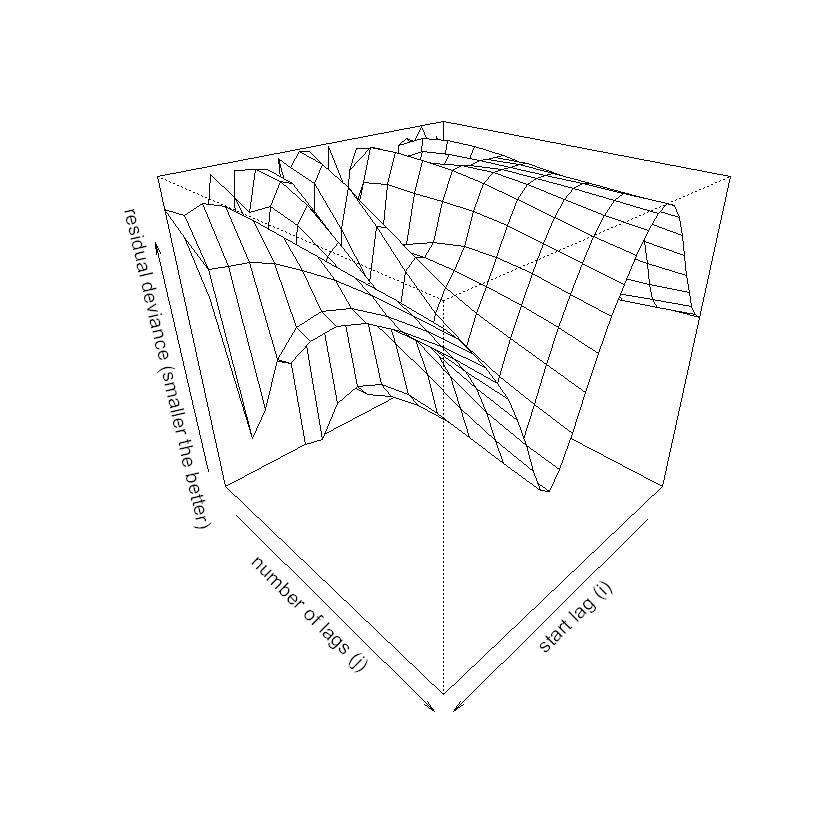

In [51]:
persp(1:nrow(result_rain_combined), 1:ncol(result_rain_combined), result_rain_combined, theta=135, phi=30, 
        xlab='start lag (i)', ylab='number of lags (j)', zlab='residual deviance (smaller the better)')
# HIGHEST LOG-LIKE
min(result_rain_combined, na.rm=T)
which(result_rain_combined==min(result_rain_combined, na.rm=T), arr.ind=TRUE)

### Model 0, the null models (no weather info)
Now I want to fit some "null" models without weather info with this new subset. We can then compare how much additional explanatory power is brought by weather info. 

In [4]:
# NULL MODEL WITHOUT WEATHER INFO 
# JUST month.assigned AND VILLAGE. THE INTERACTION IS HERE TO STAY (CHECKED)
overdispersion<-1:nrow(dat2)
m_0A<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village, 
             family='poisson', data=dat2, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_0A, correlation=FALSE)

# WITH mosquito.net AND persons.status
m_0B<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion)+month.assigned*village+mosquito.net+persons.status, 
             family='poisson', data=dat2, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_0B, correlation=FALSE)

fixed-effect model matrix is rank deficient so dropping 6 columns / coefficients

Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village
   Data: dat2
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5799.7   5899.7  -2878.8   5757.7      844 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.35436 -0.35868 -0.00172  0.13043  0.59194 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.221289 1.10512 
 site.id        (Intercept) 0.691682 0.83167 
 year.assigned  (Intercept) 0.002556 0.05056 
Number of obs: 865, groups:  
overdispersion, 865; site.id, 181; year.assigned, 3

Fixed effects:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                             1.94773    0.32422   6.007 1.88e-09 ***
month.assigned

fixed-effect model matrix is rank deficient so dropping 6 columns / coefficients

Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion) +  
    month.assigned * village + mosquito.net + persons.status
   Data: dat2
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5641.8   5755.5  -2796.9   5593.8      818 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.29902 -0.36065 -0.01151  0.14073  0.61803 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.195722 1.09349 
 site.id        (Intercept) 0.632651 0.79539 
 year.assigned  (Intercept) 0.004086 0.06392 
Number of obs: 842, groups:  
overdispersion, 842; site.id, 174; year.assigned, 3

Fixed effects:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                             2.334353   0.372946   6.2

In [5]:
m_0<-glmer(count.f~(1|year.assigned)+(1|site.id)+(1|overdispersion), 
             family='poisson', data=dat2, 
             control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
summary(m_0, correlation=FALSE)
anova(m_0, m_0A)
anova(m_0A, m_0B)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: count.f ~ (1 | year.assigned) + (1 | site.id) + (1 | overdispersion)
   Data: dat2
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5830.2   5849.2  -2911.1   5822.2      861 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.33201 -0.35521 -0.01319  0.13043  0.44071 

Random effects:
 Groups         Name        Variance Std.Dev.
 overdispersion (Intercept) 1.318308 1.14818 
 site.id        (Intercept) 0.829408 0.91072 
 year.assigned  (Intercept) 0.003627 0.06022 
Number of obs: 865, groups:  
overdispersion, 865; site.id, 181; year.assigned, 3

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.59409    0.09393   16.97   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
m_0,4,5830.182,5849.233,-2911.091,5822.182,NA,NA,NA
m_0A,21,5799.687,5899.704,-2878.844,5757.687,64.49518,17,1.869544e-07


ERROR: Error in anova.merMod(m_0A, m_0B): models were not all fitted to the same size of dataset


There is a warning saying some coefficients have been dropped, and that the summary table is missing several coefficient estimates. It is because some month.assigned x village combinations did not exist in our dataset. Let us have a quick look: 

In [9]:
by(dat2$count.f, interaction(dat2$month.assigned, dat2$village), mean, na.rm=T)

interaction(dat2$month.assigned, dat2$village): 1.Bana market
[1] NA
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 2.Bana market
[1] NA
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 3.Bana market
[1] NA
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 4.Bana market
[1] NA
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 5.Bana market
[1] 18.05128
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 6.Bana market
[1] 16.10345
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 7.Bana market
[1] 9.6
------------------------------------------------------------ 
interaction(dat2$month.assigned, dat2$village): 8.Bana market
[1] 12.5

We can see that in Pala and Souroukoudingan there were no data in months 05, 07, 09. This means we are unable to estimate some interaction terms, as the warning suggested earlier. 

[1] -2789.546

,row,col
result.16,16,1


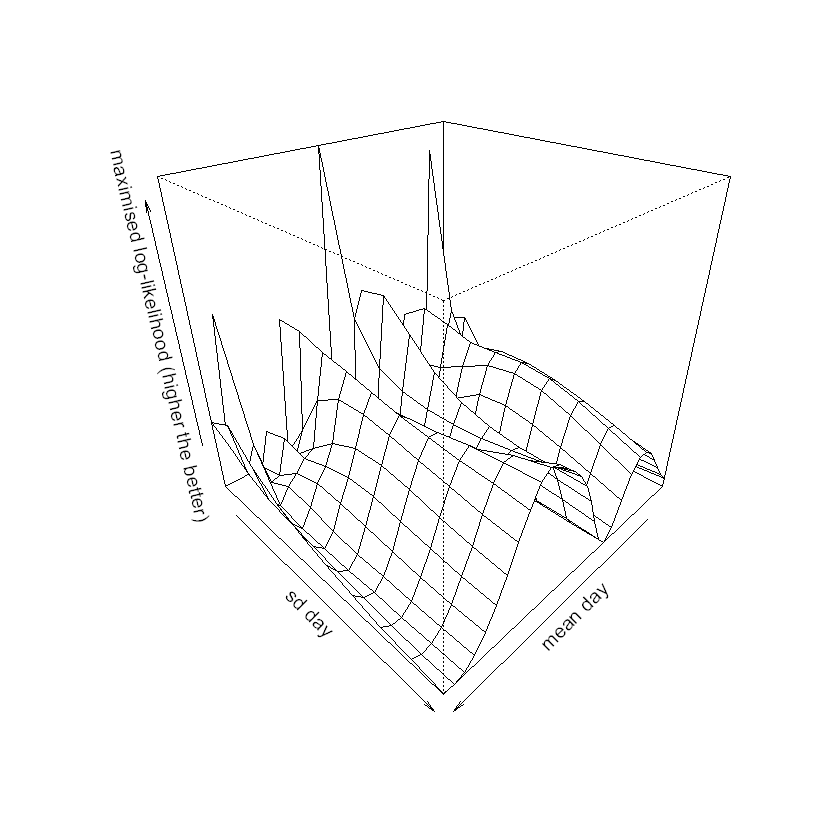

In [23]:
persp(1:nrow(result_rain_gaussian), 1:ncol(result_rain_gaussian), result_rain_gaussian, theta=135, phi=30, 
        xlab='mean day', ylab='sd day', zlab='maximised log-likelihood (higher the better)')
max(result_rain_gaussian, na.rm=T)
which(result_rain_gaussian==max(result_rain_gaussian, na.rm=T), arr.ind=TRUE)

Including past rainfall as a covariate increases explanatory power. Although it is a signficant term I would not say there is a drastic improvement. The results above differ from what I reported before because different subsets of data were used. 

### Lagged rainfall + log male count

In [25]:
dat3<-f(lag=0, lag_length=75)
#dim(dat3)
cat(paste('The 27-th column is', names(dat3)[27])) # MAKE SURE THE 27-TH COLUMN IS rain.minus.0
cl<-makeCluster(46, outfile='log.txt') # MULTIPLE CPU
registerDoParallel(cl)
result_rain2<-foreach (i=1:30, .combine=rbind, .packages='lme4') %dopar%
    {
    setMKLthreads(1)
    temp_result<-rep(NA, 21)
    for (j in 1:length(temp_result))
        {
        total.rain<-apply(as.matrix(dat3[,(i+27):(i+27+j-1)]), 1, sum, na.rm=T)
        total.rain<-scale(total.rain) # SCALE TO CENTRE
        dat3$rain.minus.0<-scale(dat3$rain.minus.0)
        dat3$temp.minus.0<-scale(dat3$temp.minus.0)
        log.count.m<-log(dat3$count.m+1)
        overdispersion<-1:nrow(dat3)
        m<-NA #RESET m
        m<-glmer(count.f~(1|site.id)+(1|overdispersion)+village*month.assigned+mosquito.net+persons.status
             +rain.minus.0+temp.minus.0+total.rain+log.count.m, 
            data=dat3, family='poisson', 
            control=glmerControl(optimizer="bobyqa"))
        temp_result[j]<-summary(m)$logLik
        cat(sprintf("%i, %i\n", i, j))
        }
    return(temp_result)
    }
stopCluster(cl)
dim(result_rain2)
invisible(gc())

The 27-th column is rain.minus.0

[1] 30 21

[1] -2643.981

,row,col
result.11,11,1


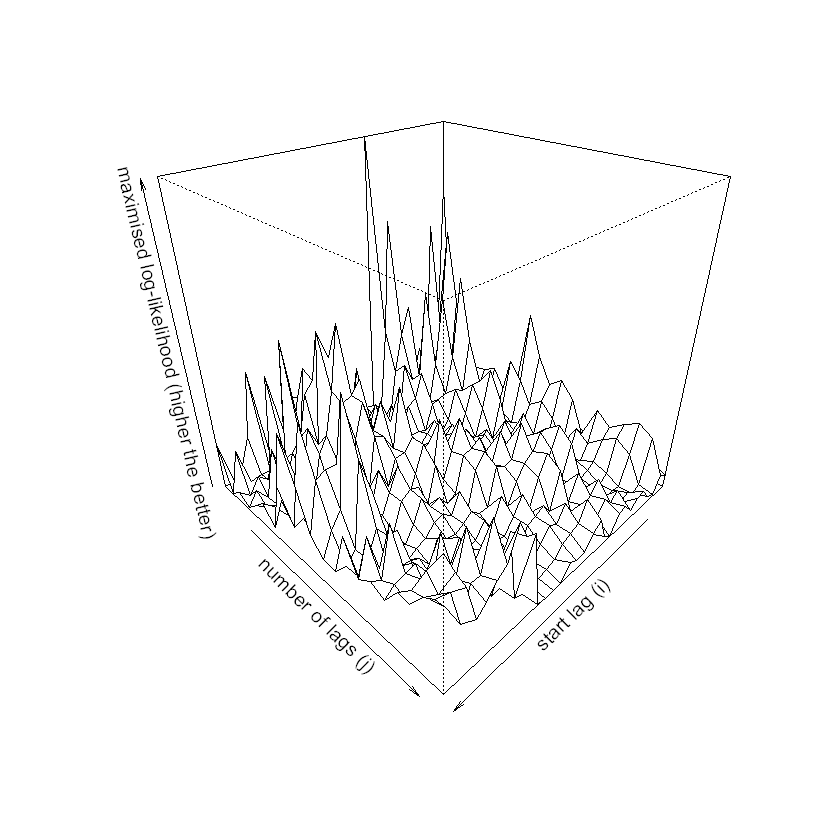

In [26]:
persp(1:nrow(result_rain2), 1:ncol(result_rain2), result_rain2, theta=135, phi=30, 
        xlab='start lag (i)', ylab='number of lags (j)', zlab='maximised log-likelihood (higher the better)')
# HIGHEST LOG-LIKE
max(result_rain2, na.rm=T)
# THE VALUE OF i AND j GIVES THE HIGHEST LOG-LIKE
which(result_rain2==max(result_rain2, na.rm=T), arr.ind=TRUE)

A different result is obtained when log male count is also included. It is safe to say that log male count is a more useful covariate as it increases the log-likelihood by 150. 